In [ ]:
from pathlib import Path
import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
import dask

In [ ]:
resolution = 4         # 4 or 12 km
projdir = Path().resolve().parents[0]

outdir = projdir / "evaluation/working"
datadir = Path(f"/import/beegfs/CMIP6/wrf_era5/{str(resolution).zfill(2)}km/")
weatherstationlist = projdir / "evaluation/auxdata/ACIS_stations.csv"
filepattern = f"era5_wrf_dscale_{resolution}km"
chunking = {
    4: [225, 210],
    12: ['auto', 'auto']
}

In [ ]:
stations = pd.read_csv(weatherstationlist)
teststation = 'FAIRBANKS INTL AP'

def getlatlon(station, stationDF=stations, lon360=True):
    lat = stationDF[stationDF.name == station].latitude.item()
    if lon360:
        lon = stationDF[stationDF.name == station].longitude.item() % 360
    else:
        lon = stationDF[stationDF.name == station].longitude.item()
    return lat, lon

def getarrayindices(mylat, mylon, sampledatapath, l1norm=True):
    with xr.open_dataset(sampledatapath) as src:
        abslat = np.abs(src.XLAT-mylat)
        abslon = np.abs(src.XLONG-mylon)
        if l1norm:
            d = np.maximum(abslon, abslat)
        else:
            d = abslon**2 + abslat**2
    ([xloc], [yloc]) = np.where(d == np.min(d))
    return xloc, yloc

test_lat, test_lon = getlatlon(teststation, lon360=False)
test_lat, test_lon

(64.80309, -147.87605)

Open _one_ data file to retrieve the correct i,j value

In [ ]:
testpath = next(datadir.rglob("*.nc"))

In [ ]:
testpath

PosixPath('/import/beegfs/CMIP6/wrf_era5/04km/1982/era5_wrf_dscale_4km_1982-08-21.nc')

In [ ]:
xloc, yloc = getarrayindices(test_lat, test_lon, testpath, l1norm=False)

xloc, yloc

(251, 261)

### invoke Dask explicitly 

In [ ]:
from dask.distributed import Client
client = Client(n_workers=50, threads_per_worker=2, memory_limit='50GB')

In [ ]:
# in case we need to clean up

client.shutdown()

In [ ]:
fpaths = sorted(list(datadir.rglob(f"{filepattern}*1982-08*.nc")))
ds = xr.open_mfdataset(fpaths,  
    parallel=True, 
    #chunks={'south_north': 225, 'west_east': 210, 'Time': 100},
    chunks="auto",
    # preprocess=lambda ds: ds[['rainc', 'rainnc', 'acsnow']]
    )

In [ ]:
rain = ds.rainnc + ds.rainc
rain['Time'] = rain['Time'].to_index() + dt.timedelta(hours=-8)

In [ ]:
rain

<xarray.DataArray (Time: 744, south_north: 450, west_east: 420)> Size: 562MB
dask.array<add, shape=(744, 450, 420), dtype=float32, chunksize=(24, 225, 210), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 756kB dask.array<chunksize=(225, 210), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 756kB dask.array<chunksize=(225, 210), meta=np.ndarray>
    XTIME    (Time) float32 3kB dask.array<chunksize=(24,), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 6kB 1982-07-31T16:00:00 ... 1982-08-31T15:...
Dimensions without coordinates: south_north, west_east

Exception ignored in: <function CachingFileManager.__del__ at 0x7fad8dd66fc0>
Traceback (most recent call last):
  File "/import/FIREICE/fiboreal/cwaigl/.conda/envs/dyndown/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/import/FIREICE/fiboreal/cwaigl/.conda/envs/dyndown/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2618, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2585, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2113, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


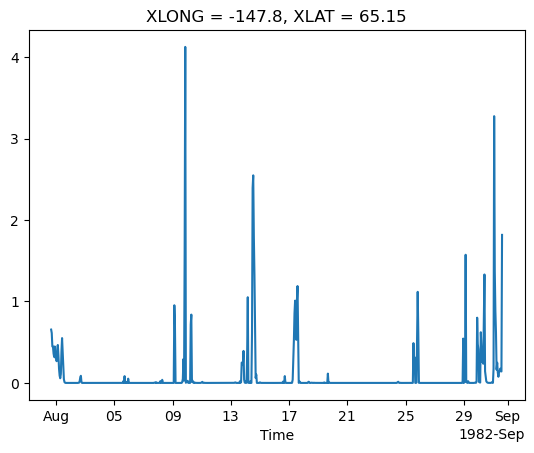

In [ ]:
rain.isel(south_north=yloc, west_east=yloc).plot()

In [ ]:
concat = []
for testdate in dates:
    with xr.open_dataset(datadir / f"{testdate[:4]}/{filepattern}_{testdate}.nc") as src:
        rain = src.rainnc + src.rainc
        rain['Time'] = rain['Time'].to_index() + dt.timedelta(hours=-8)
    concat.append(rain.isel(south_north=yloc, west_east=yloc))

In [ ]:
all_rain = xr.concat(concat, dim='Time').to_dataframe(name='rain').drop(columns=['XLAT', 'XLONG', 'XTIME'])

In [ ]:
all_rain_daily = all_rain.resample('D').sum()

<Axes: xlabel='Time'>

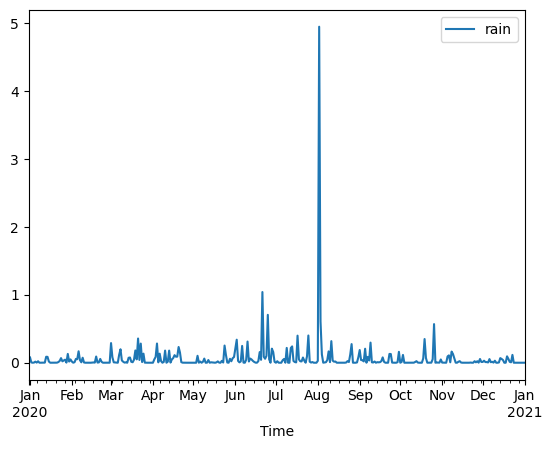

In [ ]:
all_rain_daily.plot()

### add rain from ACIS

In [ ]:
weatherstationframes[teststation]['2011-01-01':'2020-12-31']

,Tmax_f,Tmin_F,Tavg_F,precip_in,sd_m,swe,year
2011-01-01,35,-5,15.0,0.01,13,-9999,2011
2011-01-02,41,12,26.5,0.00,13,-9999,2011
2011-01-03,25,7,16.0,0.00,13,-9999,2011
2011-01-04,30,13,21.5,0.01,12,-9999,2011
2011-01-05,23,-6,8.5,0.00,12,-9999,2011
...,...,...,...,...,...,...,...
2020-12-27,9,-13,-2.0,0.00,15,-9999,2020
2020-12-28,20,2,11.0,0.00,15,-9999,2020
2020-12-29,19,-8,5.5,0.00,15,-9999,2020
2020-12-30,1,-10,-4.5,0.00,15,-9999,2020


In [ ]:
precipDF = pd.DataFrame(weatherstationframes[teststation]['precip_in'] * 2.54)
precipDF.replace(-9999* 2.54, np.nan, inplace=True)
precipDF.columns = ['precip_cm']
precipDF['2011-01-01':'2020-12-31']

,precip_cm
2011-01-01,0.0254
2011-01-02,0.0000
2011-01-03,0.0000
2011-01-04,0.0254
2011-01-05,0.0000
...,...
2020-12-27,0.0000
2020-12-28,0.0000
2020-12-29,0.0000
2020-12-30,0.0000


<Axes: >

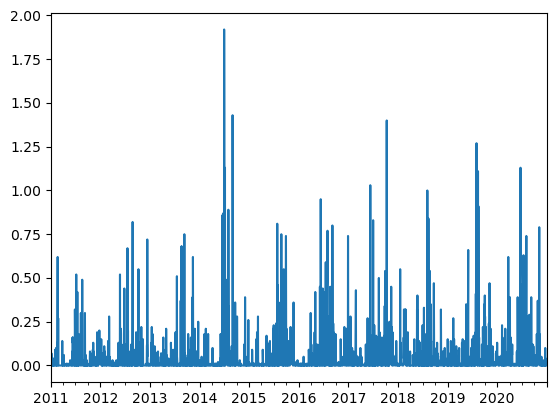

In [ ]:
weatherstationframes[teststation]['2011-01-01':'2020-12-31']['precip_in'].plot()
# plt.ylim([0, 1])

<Axes: xlabel='Time'>

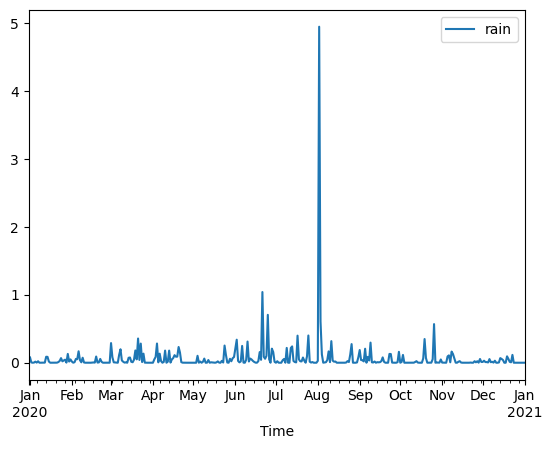

In [ ]:
all_rain_daily.plot()

In [ ]:
compDF = all_rain_daily[1:-1].merge(precipDF['2020-01-01':'2020-12-31'], left_index=True, right_index=True )
compDF

,rain,precip_mm
Time,,
2020-01-01,0.083123,6.096
2020-01-02,0.004121,0.254
2020-01-03,0.000000,0.000
2020-01-04,0.002172,0.000
2020-01-05,0.015902,0.000
...,...,...
2020-12-27,0.000163,0.000
2020-12-28,0.000391,0.254
2020-12-29,0.000160,0.000


In [ ]:
compDF['month'] = compDF.index.month

In [ ]:
compDF

,rain,precip_mm,month
Time,,,
2020-01-01,0.083123,6.096,1
2020-01-02,0.004121,0.254,1
2020-01-03,0.000000,0.000,1
2020-01-04,0.002172,0.000,1
2020-01-05,0.015902,0.000,1
...,...,...,...
2020-12-27,0.000163,0.000,12
2020-12-28,0.000391,0.254,12
2020-12-29,0.000160,0.000,12


In [ ]:
import seaborn as sns

(0.0, 10.0)

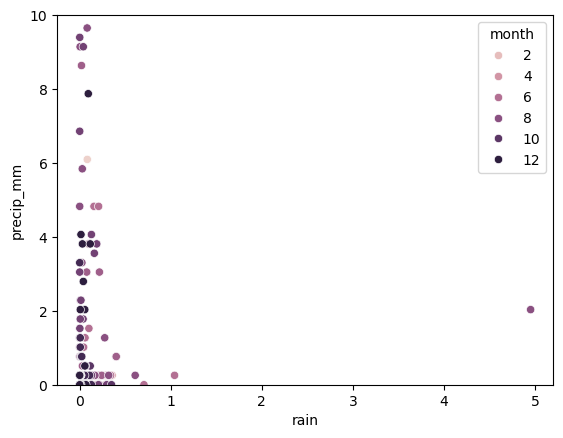

In [ ]:
ax = sns.scatterplot(data=compDF, x='rain', y='precip_mm', hue='month')
ax.set_ylim([0, 10])


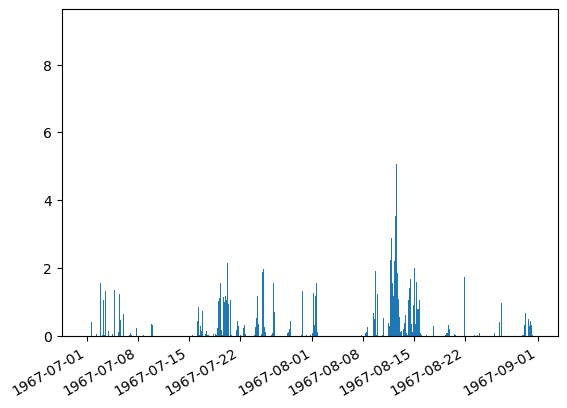

In [ ]:
interval = dt.timedelta(hours=1)     # <----- timedelta of 1 hour

fig, ax = plt.subplots()
ax.bar(all_rain.index, all_rain.rain, width=interval)
fig.autofmt_xdate()

### Comparison w/ NCEI hourly data

In [ ]:
rainDF = pd.read_csv('FAI_PAFA_hourly_precip_NCEI.csv')
rainDF['datetime'] = pd.to_datetime(rainDF.DATE)
rainDF['HPCP'] = rainDF.HPCP.replace(999.99, 0).replace(0.01, 0) * 25.4
rainDF

,STATION,STATION_NAME,DATE,HPCP,datetime
0,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,19500101 01:00,0.000,1950-01-01 01:00:00
1,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,19500101 11:00,0.762,1950-01-01 11:00:00
2,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,19500101 12:00,0.508,1950-01-01 12:00:00
3,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,19500101 13:00,0.508,1950-01-01 13:00:00
4,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,19500101 14:00,0.762,1950-01-01 14:00:00
...,...,...,...,...,...
42191,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,20131001 13:00,0.000,2013-10-01 13:00:00
42192,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,20131101 01:00,0.000,2013-11-01 01:00:00
42193,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,20131201 00:00,0.000,2013-12-01 00:00:00
42194,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,20131201 01:00,0.000,2013-12-01 01:00:00


In [ ]:
dt.datetime.strptime(startdate, '%Y-%m-%d')

datetime.datetime(1967, 7, 1, 0, 0)

In [ ]:
mask = ((rainDF['datetime'] > dt.datetime.strptime(startdate, '%Y-%m-%d')) & 
        (rainDF['datetime'] <= dt.datetime.strptime(enddate, '%Y-%m-%d')))

In [ ]:
bothDF = rainDF.loc[mask].drop(columns=['STATION', 'STATION_NAME', 'DATE']).set_index('datetime').merge(all_rain, how='left', left_index=True, right_index=True)
bothDF.columns = ['COOP:502968', 'ERA5 4 km']

Text(0, 0.5, 'mm')

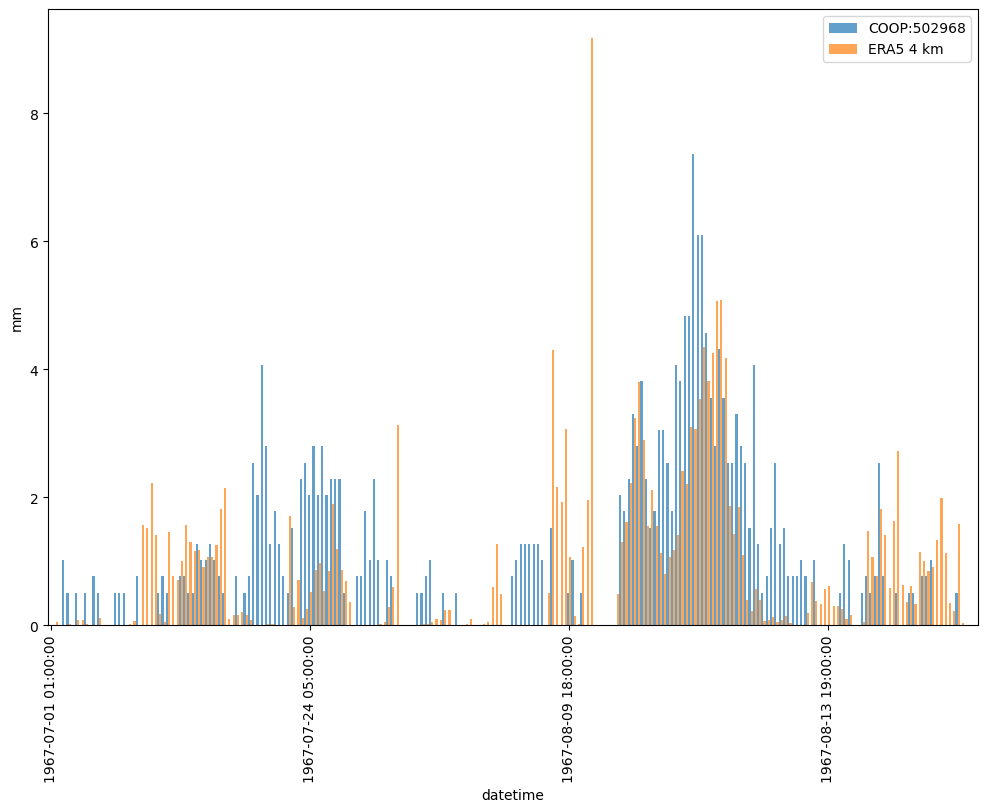

In [ ]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12, 8))
bothDF.plot(kind='bar', alpha=0.7, width=1, ax=ax)
ax.xaxis.get_major_locator()                    # <matplotlib.ticker.FixedLocator at 0x2221f657340>
ax.xaxis.get_major_formatter()                  # <matplotlib.ticker.FuncFormatter at 0x2221f8e2a00>

ax.xaxis.set_major_locator(MultipleLocator(60))  # show every 5th tick
plt.ylabel('mm')

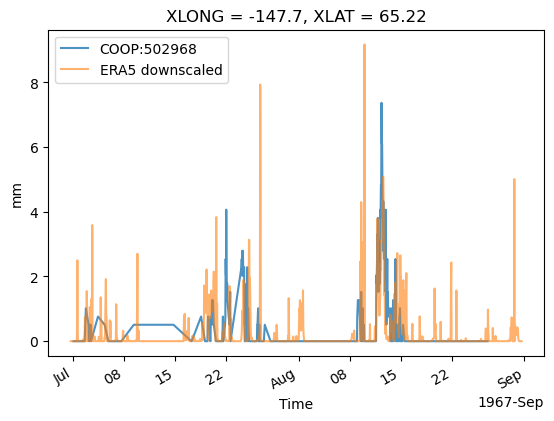

In [ ]:
ax = (rainDF.loc[mask].set_index('datetime').HPCP).plot(label='COOP:502968', alpha=0.8)
xr.concat(concat, dim='Time').plot(ax=ax, alpha=0.6, label='ERA5 downscaled')
plt.ylabel('mm')
plt.legend()